In [1]:
from init import *

In [18]:
value_dict = pd.read_pickle('./data/factor_dict.pkl')
ic_df = pd.read_pickle('./data/ic_df.pkl')

In [21]:
value_dict['liq_turn_avg'].std(axis = 1)

datetime
2016-02-01    1.0
2016-02-02    1.0
2016-02-03    1.0
2016-02-04    1.0
2016-02-05    1.0
             ... 
2023-06-26    1.0
2023-06-27    1.0
2023-06-28    1.0
2023-06-29    1.0
2023-06-30    1.0
Length: 1801, dtype: float64

In [15]:
compare = ic_analyse(ic_df)
compare = compare[compare.IR.abs() >= 0.35]
pass_icir_factor = compare.index.tolist()

In [16]:
compare

,IC,IR,last_3y,last_1y,last_3m
liq_turn_avg,0.095730,0.910500,0.786850,0.966165,0.228505
liq_zamount,0.058887,1.017844,0.815493,0.712445,-0.107678
corr_price_turn,0.064953,0.965118,0.629253,0.663784,-0.647898
mmt_normal_M,0.054143,0.540213,0.506838,0.517576,-0.380198
rat_mrq_ttm,0.029704,0.427697,0.401644,0.122062,0.579859
ccr_mrq,0.019297,0.426976,0.413802,0.630273,0.743542
dp_ttm,0.035603,0.596828,0.489731,0.790382,1.078395
liq_vstd,0.065896,0.764712,0.550434,1.058039,0.310308
mmt_overmight_M,0.031321,0.586942,0.459043,0.575550,1.082737
gpmd_ttm,0.035077,0.572165,0.368898,0.320430,1.101440


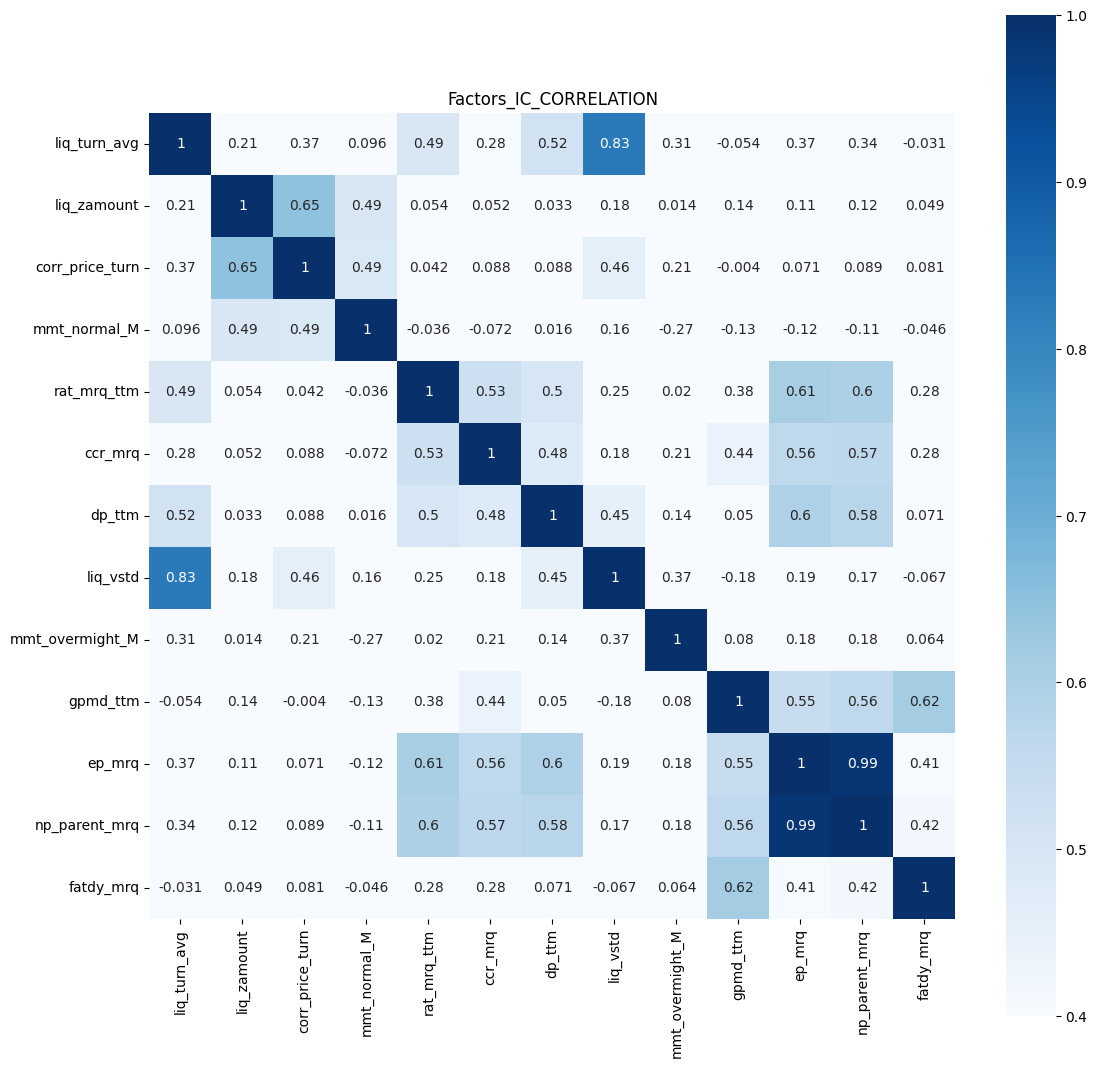

In [36]:
hot_corr(pass_icir_factor,ic_df)

In [37]:
pass_icir_factor.remove('np_parent_mrq')
pass_icir_factor.remove('liq_vstd')

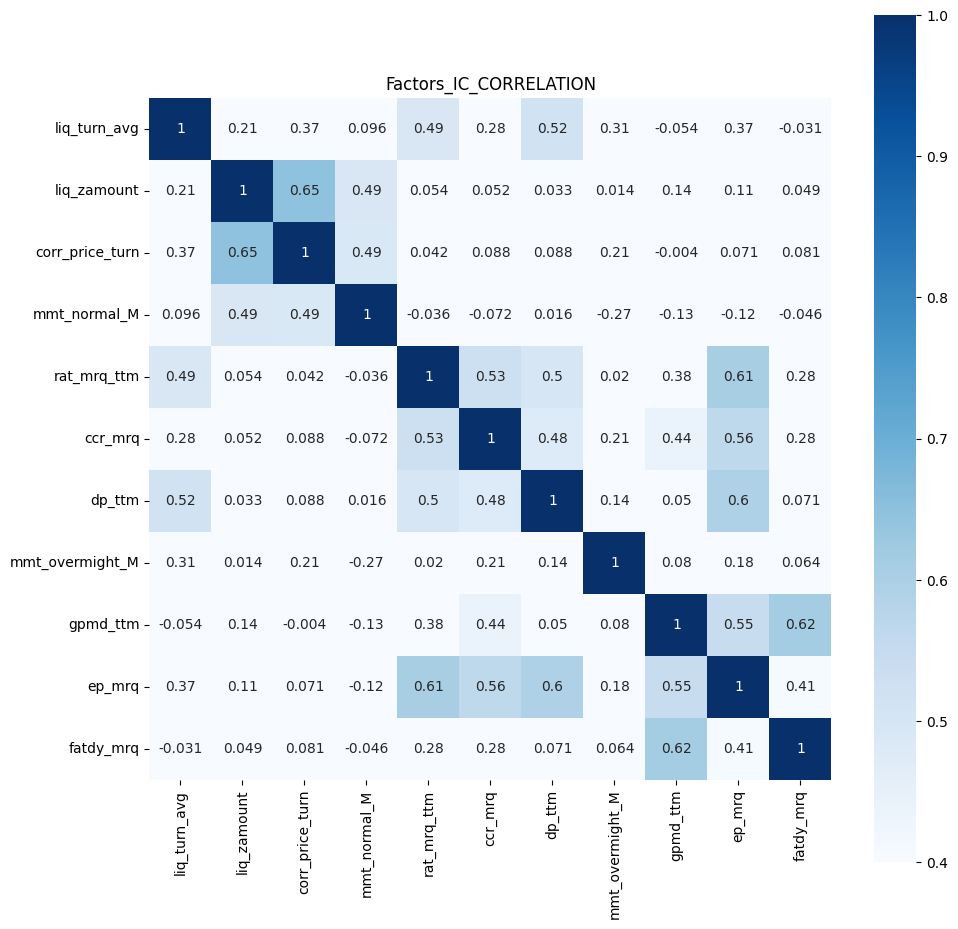

In [38]:
hot_corr(pass_icir_factor,ic_df)

In [17]:
print(pass_icir_factor)

['liq_turn_avg', 'liq_zamount', 'corr_price_turn', 'mmt_normal_M', 'rat_mrq_ttm', 'ccr_mrq', 'dp_ttm', 'liq_vstd', 'mmt_overmight_M', 'gpmd_ttm', 'ep_mrq', 'np_parent_mrq', 'fatdy_mrq']


In [28]:
','.join(factor_in)

'liq_zamount,liq_turn_avg,gpmd_ttm,corr_price_turn,mmt_overmight_M'

## 因子合成

### Stepwise ICIR

In [39]:
#================================================================================================================
# 待加入因子 stepforward_ir_name
# 前置因子模型中的因子（每一次循环都会更新）
stepforward_ir_name = compare.loc[pass_icir_factor].sort_values(by = 'IR',ascending = False).index.tolist()

factor_in = [stepforward_ir_name[0]]
T = 0
while T <= len(stepforward_ir_name):
    # 前置因子模型值
    init_factor = pd.DataFrame()
    for i in factor_in:
        init_factor = init_factor.add(value_dict[i],fill_value=0)

    #init_factor = data_clean(init_factor)
    # 前置因子的IR
    df,ic = Quick_Factor_Return_N_IC(init_factor,20,','.join(factor_in))
    ir_init_factor_test = ic['IR'][0]   # Top_return

    # 循环加入因子对比
    other_factor = set(stepforward_ir_name) - set(factor_in)
    other_factor = list(other_factor)

    new_ir_whole = []
    for j in other_factor:
        df = init_factor.add(value_dict[j],fill_value = 0)
        df,ic = Quick_Factor_Return_N_IC(df,20,','.join(factor_in) + ',' + j)
        new_ir = ic['IR'][0]
        print(factor_in,j,new_ir)
        new_ir_whole.append(new_ir)

    if max(new_ir_whole) > ir_init_factor_test:
        factor_best = list(other_factor)[new_ir_whole.index(max(new_ir_whole))]
        factor_in.append(factor_best)
        print('已训练完一层，当前最优：{},引入因子：{}'.format(max(new_ir_whole),factor_best))
    else:
        print('stepforward过程结束')
        break

    T += 1

print(factor_in)

compare.loc[factor_in]

{'name': 'liq_zamount', 'IC mean': 0.0589, 'IC std': 0.0579, 'IR': 1.0178, 'IR_ly': 0.7189, 'IC>0': 0.8417, 'ABS_IC>2%': 0.8243, 't_stat': 42.9551}
{'name': 'liq_zamount,dp_ttm', 'IC mean': 0.066, 'IC std': 0.058, 'IR': 1.1372, 'IR_ly': 0.9938, 'IC>0': 0.8782, 'ABS_IC>2%': 0.8686, 't_stat': 47.9936}
['liq_zamount'] dp_ttm 1.1372
{'name': 'liq_zamount,mmt_normal_M', 'IC mean': 0.07, 'IC std': 0.0864, 'IR': 0.81, 'IR_ly': 0.6785, 'IC>0': 0.7844, 'ABS_IC>2%': 0.8473, 't_stat': 34.1848}
['liq_zamount'] mmt_normal_M 0.81
{'name': 'liq_zamount,corr_price_turn', 'IC mean': 0.0708, 'IC std': 0.0657, 'IR': 1.0784, 'IR_ly': 0.7548, 'IC>0': 0.8495, 'ABS_IC>2%': 0.8501, 't_stat': 45.5123}
['liq_zamount'] corr_price_turn 1.0784
{'name': 'liq_zamount,fatdy_mrq', 'IC mean': 0.0506, 'IC std': 0.0497, 'IR': 1.0175, 'IR_ly': 0.6944, 'IC>0': 0.8551, 'ABS_IC>2%': 0.785, 't_stat': 42.9384}
['liq_zamount'] fatdy_mrq 1.0175
{'name': 'liq_zamount,liq_turn_avg', 'IC mean': 0.1014, 'IC std': 0.0851, 'IR': 1.192

,IC,IR,last_3y,last_1y,last_3m
liq_zamount,0.058887,1.017844,0.815493,0.712445,-0.107678
liq_turn_avg,0.095730,0.910500,0.786850,0.966165,0.228505
gpmd_ttm,0.035077,0.572165,0.368898,0.320430,1.101440
corr_price_turn,0.064953,0.965118,0.629253,0.663784,-0.647898
mmt_overmight_M,0.031321,0.586942,0.459043,0.575550,1.082737
ep_mrq,0.057331,0.756638,0.535600,0.485856,0.848591
mmt_normal_M,0.054143,0.540213,0.506838,0.517576,-0.380198


In [40]:
step_wise_ir_ew = pd.DataFrame()
for i in factor_in:
    step_wise_ir_ew = step_wise_ir_ew.add(value_dict[i],fill_value=0)

step_wise_ir_ew.to_pickle('stepwise_ir_ew.pkl')
df,ic = Quick_Factor_Return_N_IC(step_wise_ir_ew,20,'step_wise_ir_ew') 

{'name': 'step_wise_ir_ew', 'IC mean': 0.1154, 'IC std': 0.0833, 'IR': 1.386, 'IR_ly': 1.1672, 'IC>0': 0.9096, 'ABS_IC>2%': 0.9304, 't_stat': 58.4897}


In [41]:
step_wise_ir_ew_neu = data_clean(step_wise_ir_ew)
df,ic = Quick_Factor_Return_N_IC(step_wise_ir_ew_neu,20,'step_wise_ir_ew_neu') 

中信行业数据已获取
动态行业数据已构建


100%|██████████| 1801/1801 [00:58<00:00, 30.87it/s]


{'name': 'step_wise_ir_ew_neu', 'IC mean': 0.1153, 'IC std': 0.083, 'IR': 1.3897, 'IR_ly': 1.1709, 'IC>0': 0.9107, 'ABS_IC>2%': 0.9287, 't_stat': 58.6472}


In [2]:
step_wise_ir_ew = pd.read_pickle('stepwise_ir_ew.pkl')

In [3]:
step_wise_ir_ew

,000005.XSHE,000006.XSHE,000008.XSHE,000010.XSHE,000011.XSHE,000014.XSHE,000016.XSHE,000018.XSHE,000019.XSHE,000025.XSHE,...,688707.XSHG,688711.XSHG,688733.XSHG,688739.XSHG,688776.XSHG,688778.XSHG,688788.XSHG,688789.XSHG,688798.XSHG,688800.XSHG
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-01,NaN,NaN,1.825835,-3.099932,1.238234,1.391359,-3.606243,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-02,NaN,NaN,2.906908,-3.036357,1.026919,0.410043,-3.242280,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-03,NaN,NaN,2.971557,-3.214582,-2.016217,-0.867369,-3.501455,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-04,NaN,NaN,2.939815,-2.512241,NaN,-0.819021,-4.415428,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-05,NaN,NaN,2.394691,-2.847839,NaN,-1.493184,-4.526999,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,NaN,-1.176644,NaN,NaN,-3.592571,NaN,-1.295125,NaN,-1.290348,-11.157706,...,0.306598,6.481851,-1.629678,-0.767868,-1.130861,NaN,NaN,5.030214,5.493094,-0.900418
2023-06-27,NaN,-1.182918,NaN,NaN,-3.554122,NaN,-0.803201,NaN,-1.860690,-10.664043,...,0.255460,6.757187,-1.029580,-1.306180,-1.182183,NaN,NaN,4.589451,5.894269,-2.755378
2023-06-28,NaN,-1.444269,NaN,NaN,-4.011357,NaN,-0.498305,NaN,-1.540360,-11.056445,...,0.949846,6.388778,-0.790092,-1.425467,-0.160119,NaN,NaN,4.745481,5.548954,-3.298288


100%|██████████| 90/90 [00:07<00:00, 12.17it/s]



 correlation: 0.9613401473267971


,净值,年化收益率,夏普比率,最大回测,波动率,日平均换手率
net,2.5549,14.83,0.51,32.29,23.19,0.07327
benchmark,0.9058,-1.45,-0.18,51.97,24.12,0.07327
alpha,2.8206,16.52,2.03,9.22,6.66,0.07327


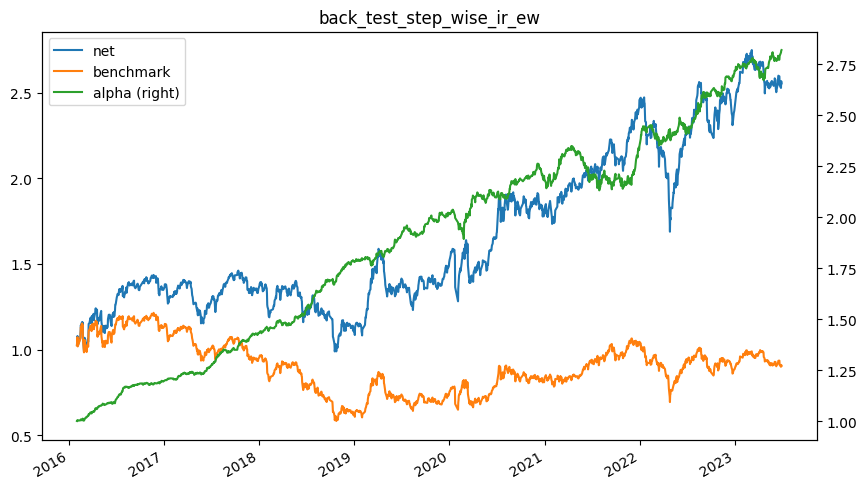

In [7]:
net,performance = BACKTEST(step_wise_ir_ew,'step_wise_ir_ew',n = 100,change_days = 20,benchmark='000852.XSHG')
performance

### Stepwise 多头组收益

In [91]:
top_ret_dict = {}
for i in tqdm(pass_icir_factor):
    top_ret_dict[i] = top_ret(value_dict[i])

100%|██████████| 11/11 [00:59<00:00,  5.45s/it]


In [94]:
pd.DataFrame([top_ret_dict]).T

,0
liq_turn_avg,0.099509
liq_zamount,0.086067
corr_price_turn,0.081609
mmt_normal_M,0.026139
rat_mrq_ttm,0.050896
ccr_mrq,0.009165
dp_ttm,0.090403
mmt_overmight_M,0.005044
gpmd_ttm,0.043270
ep_mrq,0.096076


In [96]:
""" 因子合成 方法四 Stepwise Top_return目标 """
#================================================================================================================
# 待加入因子 stepforward_ir_name
# 前置因子模型中的因子（每一次循环都会更新）
top_return = pd.DataFrame([top_ret_dict]).T
factor_in = [top_return.index[0]]

T = 0
while T <= len(stepforward_ir_name):
    # 前置因子模型值
    init_factor = pd.DataFrame()
    for i in factor_in:
        init_factor = init_factor.add(value_dict[i],fill_value=0)

    # 前置因子的IR
    ir_init_factor_test = top_ret(init_factor,','.join(factor_in))

    # 循环加入因子对比
    other_factor = set(stepforward_ir_name) - set(factor_in)
    other_factor = list(other_factor)

    new_ir_whole = []
    for i in other_factor:
        df = init_factor.add(value_dict[i],fill_value = 0)
        new_ir = top_ret(df,','.join(factor_in) + ',' + j)
        print(factor_in,i,new_ir)
        new_ir_whole.append(new_ir)

    if max(new_ir_whole) > ir_init_factor_test:
        factor_best = list(other_factor)[new_ir_whole.index(max(new_ir_whole))]
        factor_in.append(factor_best)
        print('已训练完一层，当前最优：{},引入因子：{}'.format(max(new_ir_whole),factor_best))
    else:
        print('stepforward过程结束')
        break

    T += 1

print(factor_in)

compare.loc[factor_in]

100%|██████████| 90/90 [00:04<00:00, 21.44it/s]


['liq_turn_avg'] dp_ttm 0.12876773216485327


100%|██████████| 90/90 [00:04<00:00, 22.36it/s]


['liq_turn_avg'] mmt_normal_M 0.07353718738156556


100%|██████████| 90/90 [00:04<00:00, 20.55it/s]


['liq_turn_avg'] corr_price_turn 0.12821814629247674


100%|██████████| 90/90 [00:05<00:00, 15.72it/s]


['liq_turn_avg'] fatdy_mrq 0.07003739175947676


100%|██████████| 90/90 [00:07<00:00, 12.44it/s]


['liq_turn_avg'] liq_zamount 0.11094284842053326


100%|██████████| 90/90 [00:06<00:00, 14.79it/s]


['liq_turn_avg'] mmt_overmight_M 0.08730725296531117


100%|██████████| 90/90 [00:04<00:00, 20.07it/s]


['liq_turn_avg'] gpmd_ttm 0.11438405667379237


100%|██████████| 90/90 [00:04<00:00, 20.47it/s]


['liq_turn_avg'] rat_mrq_ttm 0.07510852087855757


100%|██████████| 90/90 [00:04<00:00, 20.41it/s]


['liq_turn_avg'] ep_mrq 0.1280363389388275


100%|██████████| 90/90 [00:04<00:00, 21.09it/s]


['liq_turn_avg'] ccr_mrq 0.09354912267811799
已训练完一层，当前最优：0.12876773216485327,引入因子：dp_ttm


100%|██████████| 90/90 [00:04<00:00, 20.95it/s]


['liq_turn_avg', 'dp_ttm'] mmt_normal_M 0.10991799338670671


100%|██████████| 90/90 [00:04<00:00, 20.88it/s]


['liq_turn_avg', 'dp_ttm'] fatdy_mrq 0.11104903634082208


100%|██████████| 90/90 [00:04<00:00, 20.29it/s]


['liq_turn_avg', 'dp_ttm'] corr_price_turn 0.14983661783213376


100%|██████████| 90/90 [00:04<00:00, 19.70it/s]


['liq_turn_avg', 'dp_ttm'] liq_zamount 0.1373759864248567


100%|██████████| 90/90 [00:04<00:00, 19.91it/s]


['liq_turn_avg', 'dp_ttm'] mmt_overmight_M 0.12415659560724679


100%|██████████| 90/90 [00:04<00:00, 18.81it/s]


['liq_turn_avg', 'dp_ttm'] gpmd_ttm 0.13736316219360178


100%|██████████| 90/90 [00:04<00:00, 18.05it/s]


['liq_turn_avg', 'dp_ttm'] rat_mrq_ttm 0.12013427239468122


100%|██████████| 90/90 [00:04<00:00, 18.38it/s]


['liq_turn_avg', 'dp_ttm'] ep_mrq 0.1291722977358445


100%|██████████| 90/90 [00:05<00:00, 17.27it/s]


['liq_turn_avg', 'dp_ttm'] ccr_mrq 0.10960423622909765
已训练完一层，当前最优：0.14983661783213376,引入因子：corr_price_turn


100%|██████████| 90/90 [00:03<00:00, 22.85it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn'] mmt_normal_M 0.13452518440661954


100%|██████████| 90/90 [00:03<00:00, 22.65it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn'] fatdy_mrq 0.13311103969191973


100%|██████████| 90/90 [00:04<00:00, 22.48it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn'] liq_zamount 0.13591630811518818


100%|██████████| 90/90 [00:03<00:00, 22.98it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn'] mmt_overmight_M 0.15089254190095125


100%|██████████| 90/90 [00:04<00:00, 22.35it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn'] gpmd_ttm 0.17589915097701114


100%|██████████| 90/90 [00:03<00:00, 22.54it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn'] rat_mrq_ttm 0.14834477502182963


100%|██████████| 90/90 [00:03<00:00, 22.60it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn'] ep_mrq 0.15041910054794405


100%|██████████| 90/90 [00:03<00:00, 22.64it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn'] ccr_mrq 0.1475340223687467
已训练完一层，当前最优：0.17589915097701114,引入因子：gpmd_ttm


100%|██████████| 90/90 [00:03<00:00, 22.94it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm'] mmt_normal_M 0.15414320364353995


100%|██████████| 90/90 [00:04<00:00, 22.37it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm'] fatdy_mrq 0.14738998736233344


100%|██████████| 90/90 [00:04<00:00, 21.96it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm'] liq_zamount 0.15585819673159063


100%|██████████| 90/90 [00:04<00:00, 22.37it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm'] mmt_overmight_M 0.17893835239329503


100%|██████████| 90/90 [00:09<00:00,  9.33it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm'] rat_mrq_ttm 0.14676824736486882


100%|██████████| 90/90 [00:03<00:00, 22.56it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm'] ep_mrq 0.16419359507289188


100%|██████████| 90/90 [00:04<00:00, 22.42it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm'] ccr_mrq 0.15510516072510194
已训练完一层，当前最优：0.17893835239329503,引入因子：mmt_overmight_M


100%|██████████| 90/90 [00:04<00:00, 22.30it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm', 'mmt_overmight_M'] mmt_normal_M 0.16278974881303765


100%|██████████| 90/90 [00:06<00:00, 14.85it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm', 'mmt_overmight_M'] fatdy_mrq 0.1581631338587688


100%|██████████| 90/90 [00:05<00:00, 16.15it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm', 'mmt_overmight_M'] liq_zamount 0.16069092148576947


100%|██████████| 90/90 [00:04<00:00, 19.82it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm', 'mmt_overmight_M'] ccr_mrq 0.16881180201202328


100%|██████████| 90/90 [00:04<00:00, 21.05it/s]


['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm', 'mmt_overmight_M'] rat_mrq_ttm 0.16149026157459456


100%|██████████| 90/90 [00:04<00:00, 20.88it/s]

['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm', 'mmt_overmight_M'] ep_mrq 0.17023642069547584
stepforward过程结束
['liq_turn_avg', 'dp_ttm', 'corr_price_turn', 'gpmd_ttm', 'mmt_overmight_M']


,IC,IR,last_3y,last_1y,last_3m
liq_turn_avg,0.095730,0.910500,0.786850,0.966165,0.228505
dp_ttm,0.035603,0.596828,0.489731,0.790382,1.078395
corr_price_turn,0.064953,0.965118,0.629253,0.663784,-0.647898
gpmd_ttm,0.035077,0.572165,0.368898,0.320430,1.101440
mmt_overmight_M,0.031321,0.586942,0.459043,0.575550,1.082737


In [97]:
step_wise_top_return_ew = pd.DataFrame()
for i in factor_in:
    step_wise_top_return_ew = step_wise_top_return_ew.add(value_dict[i],fill_value=0)

step_wise_top_return_ew.to_pickle('step_wise_top_return_ew.pkl')
df,ic = Quick_Factor_Return_N_IC(step_wise_top_return_ew,20,'step_wise_top_return_ew')  

{'name': 'step_wise_top_return_ew', 'IC mean': 0.1029, 'IC std': 0.0836, 'IR': 1.2313, 'IR_ly': 1.2738, 'IC>0': 0.8821, 'ABS_IC>2%': 0.9242, 't_stat': 51.9624}


In [98]:
ir_init_factor_test = top_ret(step_wise_top_return_ew,','.join(factor_in))

100%|██████████| 90/90 [00:04<00:00, 21.20it/s]


In [99]:
ir_init_factor_test

0.17893835239329503

In [6]:
step_wise_top_return_ew = pd.read_pickle('step_wise_top_return_ew.pkl')

100%|██████████| 90/90 [00:06<00:00, 12.96it/s]


 correlation: 0.9621234609346814


,净值,年化收益率,夏普比率,最大回测,波动率,日平均换手率
net,2.7846,16.30,0.60,31.62,22.20,0.061388
benchmark,0.9058,-1.45,-0.18,51.97,24.12,0.061388
alpha,3.0741,18.01,2.25,11.47,6.67,0.061388


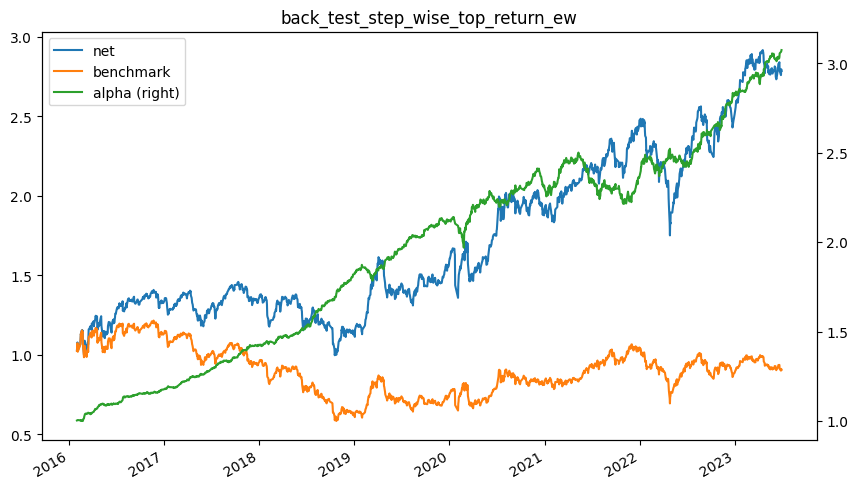

In [8]:
net,performance = BACKTEST(step_wise_top_return_ew,'step_wise_top_return_ew',n = 100,change_days = 20,benchmark='000852.XSHG')
performance